<a href="https://colab.research.google.com/github/diana-bsv/Neural_style_transfer/blob/main/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer


Оригинал\
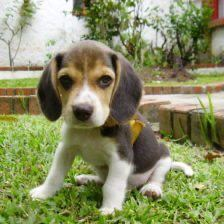

Пикассо\
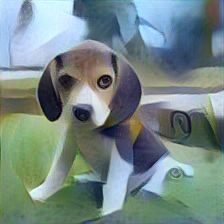

Ван Гог\
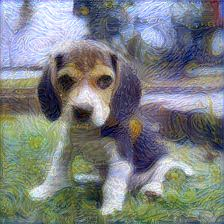

Мунк\
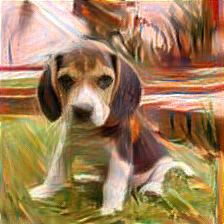

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
###
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.chosen_features = ["0", "5", "10", "19", "28"]

        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [ ]:
def prep_img(img):


  max_size=224
  img = img.convert('RGB')

  func = transforms.Compose([
        transforms.ToTensor()
    ])
  img = func(img)
  image = img.unsqueeze(0)
  return image

In [ ]:
###
model = VGG().eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def gram(feature):
  size, ch, h, w = feature.shape
  matr = feature.view(ch, h * w)
  Gr = torch.mm(matr, matr.T)/ (ch * h * w)
  return Gr

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

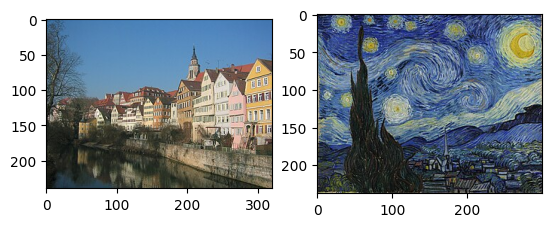

In [ ]:
img1 = Image.open('content.jpg')
img2 = Image.open('style.jpg')
img3 = Image.open('content.jpg')

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img1)
ax2.imshow(img2)

img1 = prep_img(img1)
img2 = prep_img(img2)
img3_ = prep_img(img3)

In [ ]:
import torch.optim as optim

epochs = 200 #500
learning_rate = 0.01 #0.01
alpha = 1
beta = 1e6 #1e9

img3 = img3_.to(device)
img3.requires_grad = True

optimizer = optim.Adam([img3], learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

img1 = img1.to(device)
img2 = img2.to(device)

model = model.to(device)


In [ ]:
losses = []


for epoch in tqdm(range(epochs)):


  content_loss = 0
  style_loss = 0
  optimizer.zero_grad()

  content = model(img1)[-1]
  styles = model(img2)
  results = model(img3)

  content_loss = torch.mean((content - results[-1]) ** 2)

  for result, style in zip(results, styles):
    style_loss += torch.mean((gram(result) - gram(style)) ** 2)

  total_loss = alpha * content_loss + beta * style_loss

  total_loss.backward()
  optimizer.step()
  scheduler.step()

  losses.append(total_loss.item())

  # plt.axis('off')
  # plt.imshow(img3.cpu().detach().squeeze().permute(1,2,0))
  # plt.show()


  # clear_output(wait=True)

  print(f"Epoch {epoch+1}/{epochs},     Content Loss: {alpha*content_loss.item()},    Style Loss: {beta*style_loss.item()},    Total Loss: {total_loss.item()}")



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200,     Content Loss: 0.0,    Style Loss: 274.84624297358096,    Total Loss: 274.84625244140625
Epoch 2/200,     Content Loss: 2.3608016967773438,    Style Loss: 122.63837561476976,    Total Loss: 124.99917602539062
Epoch 3/200,     Content Loss: 5.472427845001221,    Style Loss: 69.76536678848788,    Total Loss: 75.23779296875
Epoch 4/200,     Content Loss: 8.69555377960205,    Style Loss: 43.078569433419034,    Total Loss: 51.77412414550781
Epoch 5/200,     Content Loss: 9.259697914123535,    Style Loss: 30.981569580035284,    Total Loss: 40.241268157958984
Epoch 6/200,     Content Loss: 9.708250045776367,    Style Loss: 24.89424150553532,    Total Loss: 34.60249328613281
Epoch 7/200,     Content Loss: 10.469610214233398,    Style Loss: 20.57143865386024,    Total Loss: 31.041048049926758
Epoch 8/200,     Content Loss: 10.661083221435547,    Style Loss: 17.940821635420434,    Total Loss: 28.601903915405273
Epoch 9/200,     Content Loss: 10.646950721740723,    Style Loss: 16.

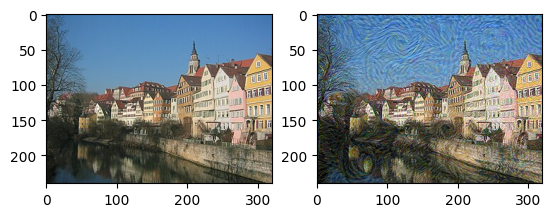

In [ ]:
save_image(img3, "generated.png")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(Image.open("content.jpg"))
ax2.imshow(Image.open("generated.png"))

In [ ]:
alpha * content_loss, beta * style_loss

(tensor(8.4127, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(2.9916, device='cuda:0', grad_fn=<MulBackward0>))

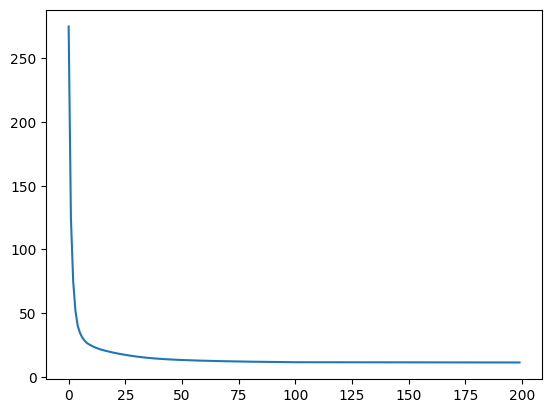

In [ ]:
plt.plot(range(len(losses[0:])), losses[0:])